In [501]:
from astropy.table import Table 
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [502]:
#  function creates desired plotting format 
def plotting( title, x_title, y_title, show = True, myfontsize=15):
    plt.xticks(fontsize=myfontsize-4)
    plt.yticks(fontsize=myfontsize-5)
    plt.title(title, fontsize= myfontsize +2)
    plt.xlabel(x_title,fontsize=myfontsize)
    plt.ylabel(y_title,fontsize=myfontsize)
    if show:
        plt.show()
colors = ["#c282f9","#a2f261","#ff7800","#31a5a9", "#a7d1ff"]


In [503]:
# Get the data
data1 = np.loadtxt("HARPS.dat")
data2 = np.loadtxt("HIRES.dat")
data = np.vstack((data1,data2))
data = data[np.argsort(data[:, 0])]
print (len(data1),' HARPS points; ',len(data2),' HIRES points')

# Add on jitter (additional noise term)
jitter = 1.2
for i in range(len(data)):
    data[i,2] = np.sqrt( data[i,2]**2 + jitter**2 )

# Initial information from Vogt et al. (2010)
Pb_sol = 5.36841; Pb_del = 0.00026; Kb_sol = 12.45
Pc_sol = 12.9191; Pc_del = 0.0058;  Kc_sol = 3.30
Pd_sol = 66.87;   Pd_del = 0.13;    Kd_sol = 1.91
Pe_sol = 3.14867; Pe_del = 0.00039; Ke_sol = 1.66
Pf_sol = 433.0;   Pf_del = 13.0;    Kf_sol = 1.30
Pg_sol = 36.562;  Pg_del = 0.052;   Kg_sol = 1.29

119  HARPS points;  122  HIRES points


In [504]:
# A full fit is tricky because it's not obvious where to initalize the phases (q) from
# So let's run a pre-fit first, wherXe we only allow the phases to vary
# Trying running this a few times and make sure the same solution is coming out

# Define model M0 fix = 4-planet model using K & P parameters fixed to the Vogt+ reported values
def M0fix(t, qb, qc, qd, qe):
    return Kb_sol*np.sin(2.0*np.pi*t/Pb_sol+qb) \
           + Kc_sol*np.sin(2.0*np.pi*t/Pc_sol+qc) \
           + Kd_sol*np.sin(2.0*np.pi*t/Pd_sol+qd) \
           + Ke_sol*np.sin(2.0*np.pi*t/Pe_sol+qe) 


# Define our parameters bounds
param_bounds = ( [-2.0*np.pi, \
                  -2.0*np.pi, \
                  -2.0*np.pi, \
                  -2.0*np.pi],\
                 [2.0*np.pi, \
                  2.0*np.pi, \
                  2.0*np.pi, \
                  2.0*np.pi] )

# Give an intial guess to help the fitting routine
initial_guess = [ np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi),\
                  np.random.uniform(-np.pi,np.pi)]

# Get the best fitting parameters
M0fix_best, M0fix_cov = curve_fit(M0fix,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

# Get the chi2
chi2 = np.dot(data[:,1] - (M0fix(data[:,0], M0fix_best[0], M0fix_best[1], M0fix_best[2], M0fix_best[3])) **2, data[:,2]**-2)


# Print output
print(chi2,len(data))
              

-6298.389759131162 241


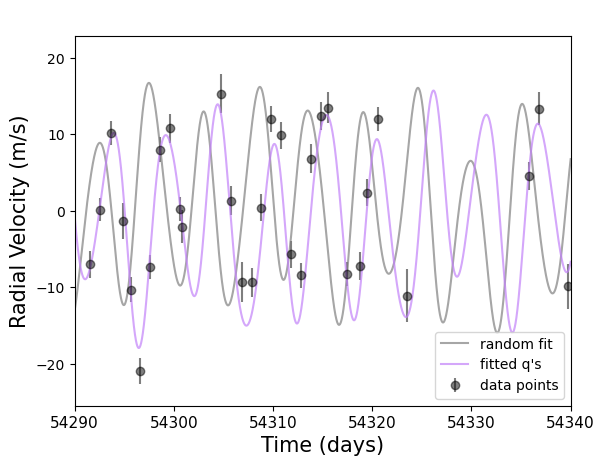

In [506]:
#plotting the fit before and after q's are adjusted

plt.errorbar(data[:, 0], data[:, 1], yerr = data[:, 2], color = 'k', alpha = 0.5,  fmt='o', label = "data points")
t = np.linspace(54290,54340, num=10000)
plt.plot(t, M0fix(t, *initial_guess), color ='grey', alpha = .7, label = "random fit")
plt.plot(t, M0fix(t, *M0fix_best), color = colors[0], alpha = .7, label = "fitted q's")
plt.xlim(54290,54340)
plt.legend(loc = 'lower right')
plotting(' ','Time (days)', 'Radial Velocity (m/s)',show = False)
plt.savefig('q shift.pdf')

In [394]:
# OK, I'm satisfied the above chi2 looks reasonable, so set the phase solutions as initial guesses

qb_sol = M0fix_best[0]
qc_sol = M0fix_best[1]
qd_sol = M0fix_best[2]
qe_sol = M0fix_best[3]

In [395]:
# Now we're ready to run the full 4-planet fit

# Define model M0 = 4-planet model
def M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe):
    return Kb*np.sin(2.0*np.pi*t/Pb+qb) \
           + Kc*np.sin(2.0*np.pi*t/Pc+qc) \
           + Kd*np.sin(2.0*np.pi*t/Pd+qd) \
           + Ke*np.sin(2.0*np.pi*t/Pe+qe)


# Define our parameters bounds
param_bounds = ( [0.0,  Pb_sol-3.0*Pb_del, -2.0*np.pi, \
                  0.0,  Pc_sol-3.0*Pc_del, -2.0*np.pi, \
                  0.0,  Pd_sol-3.0*Pd_del, -2.0*np.pi, \
                  0.0,  Pe_sol-3.0*Pe_del, -2.0*np.pi],\
                 [20.0, Pb_sol+3.0*Pb_del,  2.0*np.pi, \
                  20.0, Pc_sol+3.0*Pc_del,  2.0*np.pi, \
                  20.0, Pd_sol+3.0*Pd_del,  2.0*np.pi, \
                  20.0, Pe_sol+3.0*Pe_del,  2.0*np.pi] )

# Give an intial guess to help the fitting routine
initial_guess = [ Kb_sol, Pb_sol, qb_sol,\
                  Kc_sol, Pc_sol, qc_sol,\
                  Kd_sol, Pd_sol, qd_sol,\
                  Ke_sol, Pe_sol, qe_sol]

# Get the best fitting parameters
M0_best, M0_cov = curve_fit(M0,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess,bounds=param_bounds)

# Get the chi2
chi2_no_extra = np.dot((data[:,1] - M0(data[:,0], M0_best[0], M0_best[1], M0_best[2], M0_best[3], M0_best[4], M0_best[5], M0_best[6], M0_best[7], M0_best[8], M0_best[9], M0_best[10], M0_best[11])) **2, data[:,2]**-2)

# Get the loglike
loglike_no_extra = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2

# Print output
print( chi2_no_extra,loglike_no_extra)

390.5302652190206 2776.612358442288


# Repeating the above procedure for 5 & 6 planet models

In [397]:
#defining single planet function to be added on to 4 planet model
plus_extra_planet = lambda t, K, P, q: K*np.sin(2.0*np.pi*t/P+q)

#Define model M0 fix = 5-planet model using K & P parameters fixed to the Vogt+ reported values
#model with planet f
def M0fix_withf(t, qb, qc, qd, qe, qf):
    return M0fix(t, qb, qc, qd, qe) \
            + plus_extra_planet(t, Kf_sol, Pf_sol, qf)

#model with planet g
def M0fix_withg(t, qb, qc, qd, qe, qg):
    return M0fix(t, qb, qc, qd, qe) \
            + plus_extra_planet(t, Kg_sol, Pg_sol, qg)

#model without planet d with f and g for comparison purposes
def M0fix_withoutd(t, qb, qc, qe, qf, qg):
    return Kb_sol*np.sin(2.0*np.pi*t/Pb_sol+qb) \
           + Kc_sol*np.sin(2.0*np.pi*t/Pc_sol+qc) \
           + Ke_sol*np.sin(2.0*np.pi*t/Pe_sol+qe) \
           + plus_extra_planet(t, Kg_sol, Pg_sol, qg) \
           + plus_extra_planet(t, Kf_sol, Pf_sol, qf)
        
    
# Define model M0 fix = 6-planet model using K & P parameters fixed to the Vogt+ reported values
#model with planet f and g   
def M0fix_withfg(t, qb, qc, qd, qe, qf, qg):
    return M0fix(t, qb, qc, qd, qe) \
            + plus_extra_planet(t, Kg_sol, Pg_sol, qg) \
            + plus_extra_planet(t, Kf_sol, Pf_sol, qf)




In [398]:
# Define our parameters bounds for 5 ad 6 planet models
param_bounds_5 = (np.full(5, -2.0*np.pi), np.full(5, 2.0*np.pi))
param_bounds_6 = (np.full(6, -2.0*np.pi), np.full(6, 2.0*np.pi))

# Give an intial guess to help the fitting routine
initial_guess_5 = np.random.uniform(-np.pi,np.pi, size = 5)
initial_guess_6 = np.random.uniform(-np.pi,np.pi, size = 6)

# Get the best fitting parameters
M0fix_best_f, M0fix_cov_f   = curve_fit(M0fix_withf, data[:,0], data[:,1], sigma=data[:,2], p0=initial_guess_5, bounds=param_bounds_5)
M0fix_best_g, M0fix_cov_g   = curve_fit(M0fix_withg, data[:,0], data[:,1], sigma=data[:,2], p0=initial_guess_5, bounds=param_bounds_5)
M0fix_best_fg, M0fix_cov_fg = curve_fit(M0fix_withfg,data[:,0], data[:,1], sigma=data[:,2], p0=initial_guess_6, bounds=param_bounds_6)


# Get the chi2s
chi2_fix_f  = np.dot((data[:,1] - M0fix_withf(data[:,0],  *M0fix_best_f) ) **2, data[:,2]**-2)
chi2_fix_g  = np.dot((data[:,1] - M0fix_withg(data[:,0],  *M0fix_best_g) ) **2, data[:,2]**-2)
chi2_fix_fg = np.dot((data[:,1] - M0fix_withfg(data[:,0], *M0fix_best_fg)) **2, data[:,2]**-2)

# Print output
print ('no extra planets chi^2', chi2)
print ('chi^2 with planet f', chi2_fix_f)
print ('chi^2 with planet g', chi2_fix_g)
print ('chi^2 with planet f and g', chi2_fix_fg)



no extra planets chi^2 -6298.389316656713
chi^2 with planet f 349.5974434358844
chi^2 with planet g 347.86193582933515
chi^2 with planet f and g 302.86163444651896
chi^2 with planet f and g but no planet d 450.13502753407465


In [399]:
#getting initial guesses for these new models inputting q's found in fix models
initial_guess_f = [ Kb_sol, Pb_sol, M0fix_best_f[0],\
                    Kc_sol, Pc_sol, M0fix_best_f[1],\
                    Kd_sol, Pd_sol, M0fix_best_f[2],\
                    Ke_sol, Pe_sol, M0fix_best_f[3],\
                    Kf_sol, Pf_sol, M0fix_best_f[4]]

initial_guess_g = [ Kb_sol, Pb_sol, M0fix_best_g[0],\
                    Kc_sol, Pc_sol, M0fix_best_g[1],\
                    Kd_sol, Pd_sol, M0fix_best_g[2],\
                    Ke_sol, Pe_sol, M0fix_best_g[3],\
                    Kg_sol, Pg_sol, M0fix_best_g[4]]

initial_guess_fg = [Kb_sol, Pb_sol, M0fix_best_fg[0],\
                    Kc_sol, Pc_sol, M0fix_best_fg[1],\
                    Kd_sol, Pd_sol, M0fix_best_fg[2],\
                    Ke_sol, Pe_sol, M0fix_best_fg[3],\
                    Kf_sol, Pf_sol, M0fix_best_fg[4],\
                    Kg_sol, Pg_sol, M0fix_best_fg[5]]


In [400]:
# Now we're ready to run the full 4-planet fit

# Define model M0 = 4-planet model, M0_5planets 5-planet model

def M0_5planets(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe, K5, P5, q5):
    return M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe) \
            + plus_extra_planet(t, K5, P5, q5)

def M0_6planets(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe, K5, P5, q5, K6, P6, q6):
    return M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe) \
            + plus_extra_planet(t, K5, P5, q5) \
            + plus_extra_planet(t, K6, P6, q6)


    
# Define our parameters bounds
param_bounds_with_f = ( param_bounds[0] + [0.0,  Pf_sol-3.0*Pf_del, -2.0*np.pi],\
                        param_bounds[1] + [20.0,  Pf_sol+3.0*Pf_del, 2.0*np.pi])

param_bounds_with_g = ( param_bounds[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi],\
                        param_bounds[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi])

param_bounds_with_fg = ( param_bounds_with_f[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi],\
                         param_bounds_with_f[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi])


# Get the best fitting parameters
M0_best_f, M0_cov_f   = curve_fit(M0_5planets,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess_f, bounds=param_bounds_with_f)
M0_best_g, M0_cov_g   = curve_fit(M0_5planets,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess_g, bounds=param_bounds_with_g)
M0_best_fg, M0_cov_fg = curve_fit(M0_6planets,data[:,0],data[:,1],sigma=data[:,2],p0=initial_guess_fg,bounds=param_bounds_with_fg)

# Get the chi2
chi2_f =  np.dot((data[:,1] - M0_5planets(data[:,0], *M0_best_f )) **2, data[:,2]**-2)
chi2_g =  np.dot((data[:,1] - M0_5planets(data[:,0], *M0_best_g )) **2, data[:,2]**-2)
chi2_fg = np.dot((data[:,1] - M0_6planets(data[:,0], *M0_best_fg)) **2, data[:,2]**-2)
chis = [chi2_no_extra, chi2_f, chi2_g, chi2_fg, chi2_nod]

# Get the loglike
loglike_f  = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_f
loglike_g  = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_g
loglike_fg = -0.5*len(data)*np.log(2.0*np.pi) - np.sum( np.log(data[:,2]) ) - 0.5*chi2_fg


loglikes = [loglike_no_extra, loglike_f, loglike_g, loglike_fg, loglike_nod]

# Print output
print ('  chi^2 and likelihood with planet f', chi2_f, loglike_f)
print ('                       with planet g', chi2_g, loglike_g)
print ('                 with planet f and g', chi2_fg, loglike_fg)


  chi^2 and likelihood with planet f 345.4984714380593 -545.3315356050982
                       with planet g 341.9418465209371 -543.5532231465371
                 with planet f and g 297.53667091254766 -521.3506353423423
with planets f and g and no planet d 431.87823565121136 -588.5214177116742


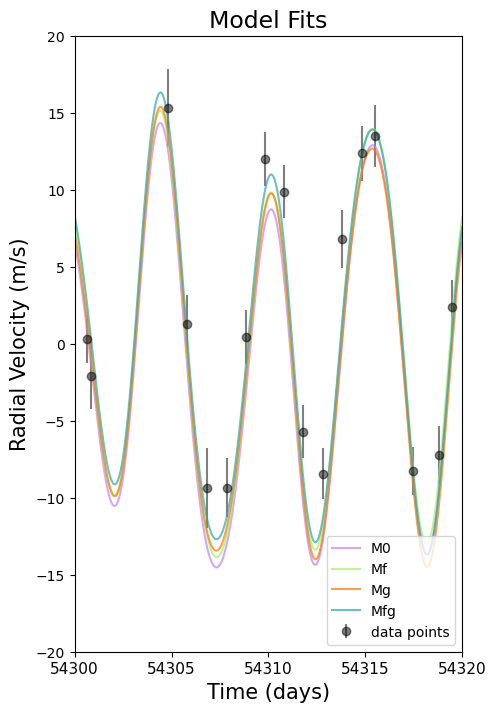

In [507]:
#plotting different model fits

plt.figure(figsize = (5,8))
plt.errorbar(data[:, 0], data[:, 1], yerr = data[:, 2], color = 'k', alpha = 0.5,  fmt='o', label = "data points")

t = np.linspace(54300,54320, num=10000)
plt.plot(t, M0(t, *M0_best), color = colors[0], alpha = .7, label = "M0")
plt.plot(t, M0_5planets(t, *M0_best_f ), color = colors[1], alpha = .7, label = "Mf")
plt.plot(t, M0_5planets(t, *M0_best_g ), color = colors[2], alpha = .7, label = "Mg")
plt.plot(t, M0_6planets(t, *M0_best_fg ), color = colors[3], alpha = .7, label = "Mfg")

plt.ylim(-20, 20)
plt.xlim(54310,54320)
plt.xticks([54300 + i*5 for i in range(5)])
plt.legend(loc = 'lower right')
plotting('Model Fits','Time (days)', 'Radial Velocity (m/s)', show = False)
plt.savefig('Model fits.pdf')

In [403]:
#Creating astropy table of the data generated above
table = Table()
table['model'] = ['orginal', 'with planet f', 'with planet g', 'with f and g', 'with f and g no d' ]
table['num of planets'] = [4., 5., 5., 6., 5]
table['chi2'] = chis
table['loglike'] = loglikes

#calculating different model comparison metrics 
table['red chi2'] = table['chi2'] / (len(data) - ( table['num of planets'] * 3))
table['BIC'] = table['chi2'] + (table['num of planets']*3* np.log(len(data)))
table['AIC'] = table['chi2'] + (table['num of planets']*3*2)
table

model,num of planets,chi2,loglike,red chi2,BIC,AIC
str17,float64,float64,float64,float64,float64,float64
orginal,4.0,390.5302652190206,2776.612358442288,1.7053723372009633,456.3478284209084,414.5302652190206
with planet f,5.0,345.4984714380593,-545.3315356050982,1.5287542983984925,427.7704254404191,375.4984714380593
with planet g,5.0,341.9418465209371,-543.5532231465371,1.5130170200041464,424.21380052329687,371.9418465209371
with f and g,6.0,297.53667091254766,-521.3506353423423,1.3342451610428145,396.2630157153794,333.53667091254766
with f and g no d,5.0,431.87823565121136,-588.5214177116742,1.9109656444743865,514.1501896535711,461.87823565121136


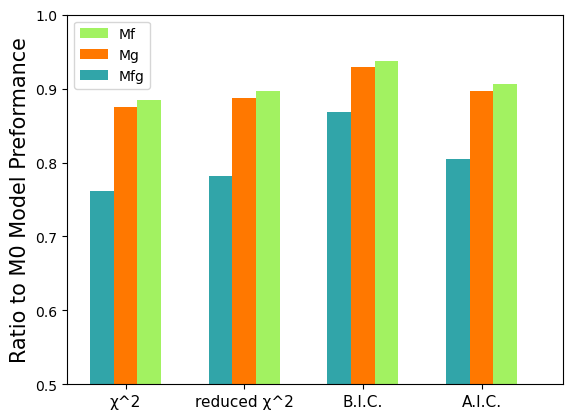

In [496]:
#showing the different comparasion metrics in a bar graph
labels = ['chi2','red chi2','BIC', 'AIC']
nice_labels = ['χ^2','reduced χ^2','B.I.C.', 'A.I.C.']
x = np.arange(4)
new_table = table[labels]
for i in labels:
    new_table[i] = table[i] / table[i][0]
width = .2

plt.bar(x+.2, new_table[1][labels], width, color = colors[1], label = 'Mf')
plt.bar(x, new_table[2][labels], width, color = colors[2],  label = 'Mg')
plt.bar(x-.2, new_table[3][labels], width, color = colors[3],  label = 'Mfg')
plt.bar(x+.4,  [0,0,0,0], width, color = colors[3])
plt.xticks(x, nice_labels)
plt.legend(loc = 'upper left')
plt.ylim(0.5,1)
plotting("", "", "Ratio to M0 Model Preformance", show = False)


plt.savefig('Model Comparison Bars.pdf')

## Creating a function to do the work done above

In [522]:
#making astropy table of the data
data_table = Table(data, names = ['time', 'RV', 'RVerr'])

In [79]:
#creating function to generate all the models as done above
def get_all_fits(time, RV, RVerr):
    '''Takes in '''
    initial_guess_fg = np.array([Kb_sol, Pb_sol, 0,  
                           Kc_sol, Pc_sol, 0, 
                           Kd_sol, Pd_sol, 0, 
                           Ke_sol, Pe_sol, 0, 
                           Kf_sol, Pf_sol, 0, 
                           Kg_sol, Pg_sol, 0])
    # note all q are zero as no given guess yet
    initial_guess   = initial_guess_fg[:12]
    initial_guess_f = initial_guess_fg[:15]
    initial_guess_g = np.concatenate((initial_guess, initial_guess_fg[-3:]))
    
    # initial q guesses
    initial_guess_q = np.random.uniform(-np.pi,np.pi, size = 6)
    
    # Define our parameters bounds
    param_boundsq_4 = (np.full(4, -2.0*np.pi), np.full(4, 2.0*np.pi))
    param_boundsq_5 = (np.full(5, -2.0*np.pi), np.full(5, 2.0*np.pi))
    param_boundsq_6 = (np.full(6, -2.0*np.pi), np.full(6, 2.0*np.pi))

    
    # Get the best fitting qs other data points fixed
    M0fix_best,    M0fix_cov    = curve_fit(M0fix,        time, RV, sigma=RVerr, p0=initial_guess_q[:4], bounds=param_boundsq_4)
    M0fix_best_f,  M0fix_cov_f  = curve_fit(M0fix_withf,  time, RV, sigma=RVerr, p0=initial_guess_q[:5], bounds=param_boundsq_5)
    M0fix_best_g,  M0fix_cov_g  = curve_fit(M0fix_withg,  time, RV, sigma=RVerr, p0=initial_guess_q[:5], bounds=param_boundsq_5)
    M0fix_best_fg, M0fix_cov_fg = curve_fit(M0fix_withfg, time, RV, sigma=RVerr, p0=initial_guess_q[:6], bounds=param_boundsq_6)
    
    # inputting fix function qs into guesses
    initial_guess[[2, 5, 8, 11]]            = M0fix_best
    initial_guess_f[[2, 5, 8, 11, 14]]      = M0fix_best_f
    initial_guess_g[[2, 5, 8, 11, 14]]      = M0fix_best_g
    initial_guess_fg[[2, 5, 8, 11, 14, 17]] = M0fix_best_fg
    
    
    # Define our parameters bounds
    param_bounds = ( [0.0,  Pb_sol-3.0*Pb_del, -2.0*np.pi, \
                      0.0,  Pc_sol-3.0*Pc_del, -2.0*np.pi, \
                      0.0,  Pd_sol-3.0*Pd_del, -2.0*np.pi, \
                      0.0,  Pe_sol-3.0*Pe_del, -2.0*np.pi],\
                    [20.0, Pb_sol+3.0*Pb_del,  2.0*np.pi, \
                     20.0, Pc_sol+3.0*Pc_del,  2.0*np.pi, \
                     20.0, Pd_sol+3.0*Pd_del,  2.0*np.pi, \
                     20.0, Pe_sol+3.0*Pe_del,  2.0*np.pi] )
    
    param_bounds_with_f = ( param_bounds[0] + [0.0,  Pf_sol-3.0*Pf_del, -2.0*np.pi],\
                            param_bounds[1] + [20.0,  Pf_sol+3.0*Pf_del, 2.0*np.pi])

    param_bounds_with_g = ( param_bounds[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi],\
                            param_bounds[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi])

    param_bounds_with_fg = ( param_bounds_with_f[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi],\
                             param_bounds_with_f[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi])


    # Get the best fitting parameters
    M0_best,   M0_cov    = curve_fit(M0,         time, RV, sigma=RVerr, p0=initial_guess,   bounds=param_bounds)
    M0_best_f, M0_cov_f  = curve_fit(M0_5planets,time, RV, sigma=RVerr, p0=initial_guess_f, bounds=param_bounds_with_f)
    M0_best_g, M0_cov_g  = curve_fit(M0_5planets,time, RV, sigma=RVerr, p0=initial_guess_g, bounds=param_bounds_with_g)
    M0_best_fg,M0_cov_fg = curve_fit(M0_6planets,time, RV, sigma=RVerr, p0=initial_guess_fg,bounds=param_bounds_with_fg)

    return M0_best, M0_best_f, M0_best_g, M0_best_fg 


# Start of cross validation choosing to hide 20% of data

In [463]:
p = int(len(data_table) * .1) #20% validation
N = 10000 #number of runs 

#creating empty tables
chi_table = np.full((N, 4), np.nan)
best_chi = np.zeros((N, 4))

for i in tqdm(range(N)):
    #splitting data
    valid_index = np.random.choice(range(len(data_table)), p)
    training_index = np.setdiff1d(range(len(data_table)), valid_index)
    
    training_dat = data_table[training_index]
    valid_dat = data_table[valid_index]
    
    
    #getting fits
    M0_best, M0_best_f, M0_best_g, M0_best_fg  = get_all_fits(training_dat['time'], training_dat['RV'], training_dat['RVerr'])
    
    #measuring against validation data
    chi2_4  = np.dot((valid_dat['RV'] - M0(valid_dat['time'],          *M0_best ))   **2, valid_dat['RVerr']**-2)
    chi2_f  = np.dot((valid_dat['RV'] - M0_5planets(valid_dat['time'], *M0_best_f )) **2, valid_dat['RVerr']**-2)
    chi2_g  = np.dot((valid_dat['RV'] - M0_5planets(valid_dat['time'], *M0_best_g )) **2, valid_dat['RVerr']**-2)
    chi2_fg = np.dot((valid_dat['RV'] - M0_6planets(valid_dat['time'], *M0_best_fg)) **2, valid_dat['RVerr']**-2)
    chi2_fg_training = np.dot((training_dat['RV'] - M0_6planets(training_dat['time'], *M0_best_fg)) **2, training_dat['RVerr']**-2)
    
    #print(chi2_fg_training/len(training_index), chi2_fg/len(valid_index))
    chis = [chi2_4, chi2_f, chi2_g, chi2_fg]
    #print(chis)
    chi_table[i, :] = chis
    best_chi[i, np.argmin(chis)] = 1
    
    

100%|█████████████████████████████████████| 10000/10000 [27:42<00:00,  6.02it/s]


In [464]:
# getting sum of how many times each model was deemed the best model
best_chi_sum = [np.sum(best_chi[:, i]) for i in range(4)] 

#getting score relative to M0 models score
print(np.array(best_chi_sum) / best_chi_sum[0])

[ 1.          4.69736842  5.48245614 32.67982456]


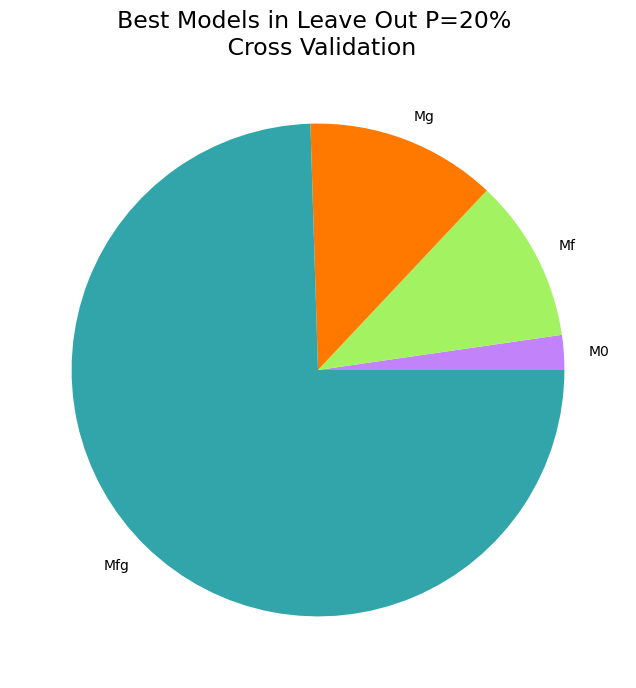

In [497]:
#plotting each models sucesses as a pie chart
new_table = table[labels]
for i in labels:
    new_table[i] = table[i] / table[i][0]
width = .9
plt.figure(figsize = (8,8))
plt.pie( best_chi_sum, colors = colors, labels = ['M0', 'Mf', 'Mg', 'Mfg'])
plotting("Best Models in Leave Out P=20% \n Cross Validation", "", "", show = False)
plt.savefig('Cross Validation Pie.pdf')

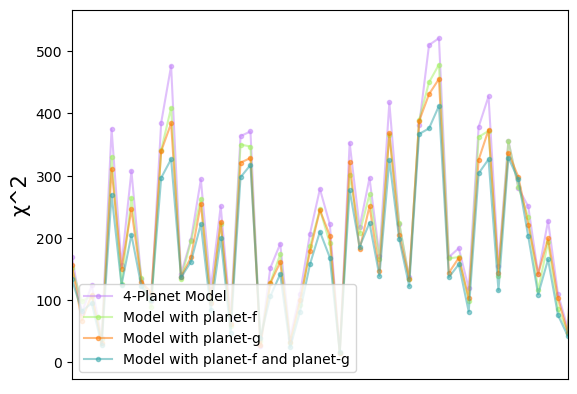

In [433]:
#plotting the χ^2 in each iteration

x = [i for i in range(N)]
plt.plot(x, chi_table[:, 0], color = colors[0], alpha = 0.5, marker = '.', label = '4-Planet Model')
plt.plot(x, chi_table[:, 1], color = colors[1], alpha = 0.5, marker = '.', label = 'Model with planet-f')
plt.plot(x, chi_table[:, 2], color = colors[2], alpha = 0.5, marker = '.', label = 'Model with planet-g')
plt.plot(x, chi_table[:, 3], color = colors[3], alpha = 0.5, marker = '.', label = 'Model with planet-f and planet-g')
plt.xlim(0, 50)
plt.legend(loc = 'lower left')
plt.xticks([])
plotting('', '', 'χ^2')


In [348]:
# exhaustive remove one cross validation


N = 10000 #number of runs 
exhaustive_chi_table = np.full((len(data_table), 4), np.nan)
exhaustive_best_chi = np.zeros((len(data_table), 4))

for i in tqdm(range(len(data_table))):
    #validation point
    valid_index = i
    #taking this point out of set
    training_index = np.setdiff1d(range(len(data_table)), valid_index)
    
    training_dat = data_table[training_index]
    valid_dat = data_table[valid_index]
    
    
    #getting fits
    M0_best, M0_best_f, M0_best_g, M0_best_fg  = get_all_fits(training_dat['time'], training_dat['RV'], training_dat['RVerr'])
    
    #measuring against validation data
    chi2_4  = np.dot((valid_dat['RV'] - M0(valid_dat['time'],          *M0_best ))   **2, valid_dat['RVerr']**-2)
    chi2_f  = np.dot((valid_dat['RV'] - M0_5planets(valid_dat['time'], *M0_best_f )) **2, valid_dat['RVerr']**-2)
    chi2_g  = np.dot((valid_dat['RV'] - M0_5planets(valid_dat['time'], *M0_best_g )) **2, valid_dat['RVerr']**-2)
    chi2_fg = np.dot((valid_dat['RV'] - M0_6planets(valid_dat['time'], *M0_best_fg)) **2, valid_dat['RVerr']**-2)
    chi2_fg_training = np.dot((training_dat['RV'] - M0_6planets(training_dat['time'], *M0_best_fg)) **2, training_dat['RVerr']**-2)
    
    
    exhaustive_chis = [chi2_4, chi2_f, chi2_g, chi2_fg]
    exhaustive_chi_table[i, :] = exhaustive_chis
    exhaustive_best_chi[i, np.argmin(exhaustive_chis)] = 1
    
    

100%|█████████████████████████████████████████| 241/241 [00:49<00:00,  4.84it/s]


In [361]:
exhaustive_best_chi_sum = [np.sum(exhaustive_best_chi[:, i]) for i in range(4)]
ratio = np.array(exhaustive_best_chi_sum)/exhaustive_best_chi_sum[0]
exhaustive_best_chi_sum

[44.0, 63.0, 57.0, 77.0]

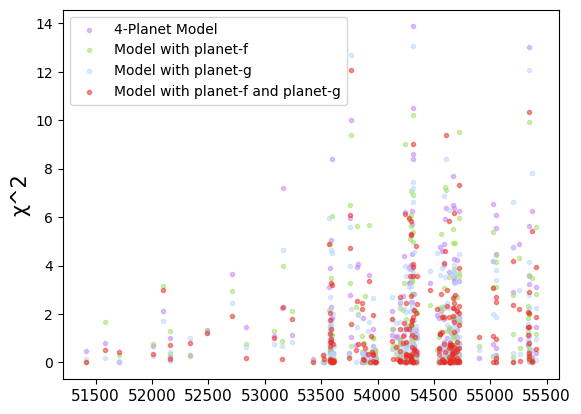

In [406]:
#plotting χ^2 of each model at each iteration
x = [i for i in range(N)]
plt.scatter(data_table['time'], exhaustive_chi_table[:, 0], color = colors[0], alpha = 0.5, marker = '.', label = '4-Planet Model')
plt.scatter(data_table['tie'], exhaustive_chi_table[:, 1], color = colors[1], alpha = 0.5, marker = '.', label = 'Model with planet-f')
plt.scatter(data_table['time'], exhaustive_chi_table[:, 2], color = colors[2], alpha = 0.5, marker = '.', label = 'Model with planet-g')
plt.scatter(data_table['time'], exhaustive_chi_table[:, 3], color = colors[3], alpha = 0.5, marker = '.', label = 'Model with planet-f and planet-g')

plt.legend(loc = 'upper left')
plotting('', '', 'χ^2')


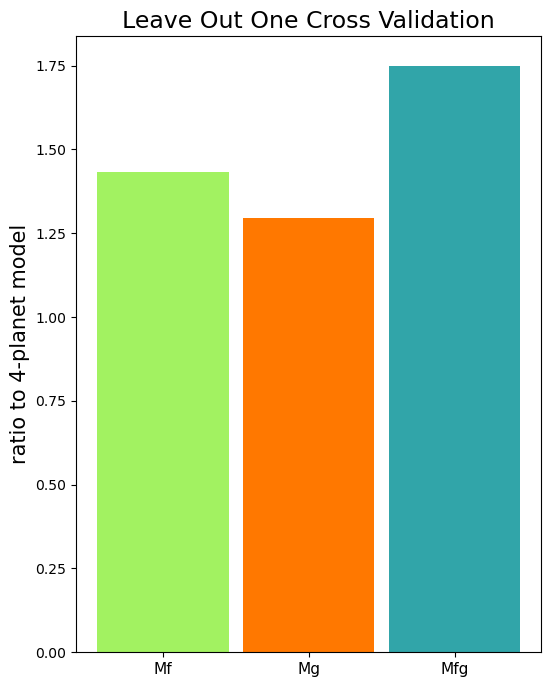

In [450]:
#showing the different comparasion metrics in a bar graph
x = np.arange(4)
new_table = table[labels]
for i in labels:
    new_table[i] = table[i] / table[i][0]
width = .9
plt.figure(figsize = (6,8))

plt.bar(1, exhaustive_best_chi_sum[1]/exhaustive_best_chi_sum[0], width, color = colors[1], label = 'Mf')
plt.bar(2, exhaustive_best_chi_sum[2]/exhaustive_best_chi_sum[0], width, color = colors[2],  label = 'Mg')
plt.bar(3, exhaustive_best_chi_sum[3]/exhaustive_best_chi_sum[0], width, color = colors[3],  label = 'Mfg')
plt.xticks([1, 2, 3], ['Mf', 'Mg', 'Mfg'])

plotting("Leave Out One Cross Validation", "", "ratio to 4-planet model")


# Add eccentric orbits Attempt not complete


In [508]:
#getting e functions
def M0e(t, Kb, Pb, qb, eb, wb, Kc, Pc, qc, ec, wc, Kd, Pd, qd, ed, wd, Ke, Pe, qe, ee, we):
    return eb*Kb*np.sin(4*np.pi*t/Pb+qb +wb) \
           + ec*Kc*np.sin(4*np.pi*t/Pc+qc +wc) \
           + ed*Kd*np.sin(4*np.pi*t/Pd+qd +wd) \
           + ee*Ke*np.sin(4*np.pi*t/Pe+qe +we)

plus_extra_planet_e = lambda t, K, P, q, e, w: e*K*np.sin(4*np.pi*t/P+q +w) + K*np.sin(2*np.pi*t/P+q)

def M0e_5planets(t,  Kb, Pb, qb, eb, wb, Kc, Pc, qc, ec, wc, Kd, Pd, qd, ed, wd, Ke, Pe, qe, ee, we, K5, P5, q5, e5, w5):
    return M0e(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe) \
            + plus_extra_planet_e(t, K5, P5, q5, e5, w5)

def M0e_6planets(t,  Kb, Pb, qb, eb, wb, Kc, Pc, qc, ec, wc, Kd, Pd, qd, ed, wd, Ke, Pe, qe, ee, we, K5, P5, q5, e5, w5, K6, P6, q6, e6, w6):
    return M0(t, Kb, Pb, qb, Kc, Pc, qc, Kd, Pd, qd, Ke, Pe, qe) \
            + plus_extra_planet_e(t, K5, P5, q5, e5, w5) \
            + plus_extra_planet_e(t, K6, P6, q6, e6, w6)


def M0fix_e(t, eb, wb, ec, wc, ed, wd, ee, we):
    return Kb_sol*np.sin(2.0*np.pi*t/Pb_sol+qb_i) \
           + Kc_sol*np.sin(2.0*np.pi*t/Pc_sol+qc_i) \
           + Kd_sol*np.sin(2.0*np.pi*t/Pd_sol+qd_i) \
           + Ke_sol*np.sin(2.0*np.pi*t/Pe_sol+qe_i) \
           + eb*Kb_sol*np.sin(4*np.pi*t/Pb_sol+qb_i +wb) \
           + ec*Kc_sol*np.sin(4*np.pi*t/Pc_sol+qc_i +wc) \
           + ed*Kd_sol*np.sin(4*np.pi*t/Pd_sol+qd_i +wd) \
           + ee*Ke_sol*np.sin(4*np.pi*t/Pe_sol+qe_i +we)

def M0fix_e_f(t, eb, wb, ec, wc, ed, wd, ee, we, ef, wf):
    return M0fix_e(t, eb, wb, ec, wc, ed, wd, ee, we) \
            + plus_extra_planet(t, Kf_sol, Pf_sol, qf_i, ef, wf)

def M0fix_e_g(t, eb, wb, ec, wc, ed, wd, ee, we, eg, wg):
    return M0fix_e(t, eb, wb, ec, wc, ed, wd, ee, we) \
            + plus_extra_planet(t, Kg_sol, Pg_sol, qg_i, eg, wf)

def M0fix_e_fg(t, eb, wb, ec, wc, ed, wd, ee, we, ef, wf, eg, wg):
    return M0fix_e(t, eb, wb, ec, wc, ed, wd, ee, we) \
            + plus_extra_planet(t, Kf_sol, Pf_sol, qf_i, ef, wf) \
            + plus_extra_planet(t, Kg_sol, Pg_sol, qg_i, eg, wf)




In [554]:
#getting initial guesses for these new models inputting q's found in fix models
initial_guess_e = np.array([ Kb_sol, Pb_sol, M0fix_best_f[0], 0, 0,\
                    Kc_sol, Pc_sol, M0fix_best_f[1], 0, 0,\
                    Kd_sol, Pd_sol, M0fix_best_f[2], 0, 0,\
                    Ke_sol, Pe_sol, M0fix_best_f[3], 0, 0])

initial_guess_f_e = np.array([ Kb_sol, Pb_sol, M0fix_best_f[0], 0, 0,\
                      Kc_sol, Pc_sol, M0fix_best_f[1], 0, 0,\
                      Kd_sol, Pd_sol, M0fix_best_f[2], 0, 0,\
                      Ke_sol, Pe_sol, M0fix_best_f[3], 0, 0,\
                      Kf_sol, Pf_sol, M0fix_best_f[4], 0, 0])

initial_guess_g_e = np.array([ Kb_sol, Pb_sol, M0fix_best_g[0],0, 0,\
                     Kc_sol, Pc_sol, M0fix_best_g[1], 0, 0,\
                     Kd_sol, Pd_sol, M0fix_best_g[2], 0, 0,\
                     Ke_sol, Pe_sol, M0fix_best_g[3], 0, 0,\
                     Kg_sol, Pg_sol, M0fix_best_g[4], 0, 0])

initial_guess_fg_e = np.array([Kb_sol, Pb_sol, M0fix_best_fg[0],0, 0,\
                     Kc_sol, Pc_sol, M0fix_best_fg[1],0, 0,\
                     Kd_sol, Pd_sol, M0fix_best_fg[2],0, 0,\
                     Ke_sol, Pe_sol, M0fix_best_fg[3],0, 0,\
                     Kf_sol, Pf_sol, M0fix_best_fg[4],0, 0,\
                     Kg_sol, Pg_sol, M0fix_best_fg[5],0, 0])


In [561]:
def get_all_fits_with_e(time, RV, RVerr):

    
    # note all q are zero as no given guess yet
    initial_guess   = initial_guess_fg[: (4*5)]
    initial_guess_f = initial_guess_fg[:(5*5)]
    initial_guess_g = np.concatenate((initial_guess, initial_guess_fg[-5:]))
    

    # Define our parameters bounds use for e fix
    param_bounds_e_4 = (np.array([0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi]),\
                        np.array([1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi]))
    
    param_bounds_e_5 = (np.array([0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi , 0, -2.0*np.pi]),\
                        np.array([1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi]))
    
    param_bounds_e_6 = (np.array([0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi, 0, -2.0*np.pi , 0, -2.0*np.pi, 0, -2.0*np.pi]),\
                        np.array([1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi, 1, 2.0*np.pi]))
    # initial q guesses
    initial_guess_q = np.random.uniform(-np.pi,np.pi, size = 6)
    
    # Define our parameters bounds
    param_boundsq_4 = (np.full(4, -2.0*np.pi), np.full(4, 2.0*np.pi))
    param_boundsq_5 = (np.full(5, -2.0*np.pi), np.full(5, 2.0*np.pi))
    param_boundsq_6 = (np.full(6, -2.0*np.pi), np.full(6, 2.0*np.pi))

    # Get the best fitting qs other data points fixed
    M0fix_best,    M0fix_cov    = curve_fit(M0fix,        time, RV, sigma=RVerr, p0=initial_guess_q[:4], bounds=param_boundsq_4)
    M0fix_best_f,  M0fix_cov_f  = curve_fit(M0fix_withf,  time, RV, sigma=RVerr, p0=initial_guess_q[:5], bounds=param_boundsq_5)
    M0fix_best_g,  M0fix_cov_g  = curve_fit(M0fix_withg,  time, RV, sigma=RVerr, p0=initial_guess_q[:5], bounds=param_boundsq_5)
    M0fix_best_fg, M0fix_cov_fg = curve_fit(M0fix_withfg, time, RV, sigma=RVerr, p0=initial_guess_q[:6], bounds=param_boundsq_6)
    
    # inputting fix function qs into guesses
    initial_guess_e[[2, 7, 12, 17]]            = M0fix_best
    initial_guess_f_e[[2, 7, 12, 17, 22]]      = M0fix_best_f
    initial_guess_g_e[[2, 7, 12, 17, 22]]      = M0fix_best_g
    initial_guess_fg_e[[2, 7, 12, 17, 22, 27]] = M0fix_best_fg
    
    qb_i, qc_i, qd_i, qe_i, qf_i, qg_i = M0fix_best_fg
    

    # Get the best fitting es other data points fixed
    M0fix_best,    M0fix_cov    = curve_fit(M0fix_e,    time, RV, sigma=RVerr, p0=initial_guess_e[:8 ], bounds=param_bounds_e_4)
    M0fix_best_f,  M0fix_cov_f  = curve_fit(M0fix_e_f,  time, RV, sigma=RVerr, p0=initial_guess_f_e[:10], bounds=param_bounds_e_5)
    M0fix_best_g,  M0fix_cov_g  = curve_fit(M0fix_e_g,  time, RV, sigma=RVerr, p0=initial_guess_g_e[:10], bounds=param_bounds_e_5)
    M0fix_best_fg, M0fix_cov_fg = curve_fit(M0fix_e_fg, time, RV, sigma=RVerr, p0=initial_guess_fg_e[:12], bounds=param_bounds_e_6)
    
    initial_guess_e[[  3,4, 8,9, 13,14, 18,19]]               = M0fix_best
    initial_guess_f_e[[3,4, 8,9, 13,14, 18,19, 23,24]]        = M0fix_best_f
    initial_guess_g_e[[3,4, 8,9, 13,14, 18,19, 23,24]]        = M0fix_best_g
    initial_guess_fg_e[[3,4,8,9, 13,14, 18,19, 23,24, 28,29]] = M0fix_best_fg

    # Define our parameters bounds
    param_bounds_e = ( [0.0,  Pb_sol-3.0*Pb_del, -2.0*np.pi, 0, -2.0*np.pi,\
                      0.0,  Pc_sol-3.0*Pc_del, -2.0*np.pi, 0, -2.0*np.pi,\
                      0.0,  Pd_sol-3.0*Pd_del, -2.0*np.pi, 0, -2.0*np.pi,\
                      0.0,  Pe_sol-3.0*Pe_del, -2.0*np.pi,0, -2.0*np.pi],\
                    [20.0, Pb_sol+3.0*Pb_del,  2.0*np.pi, 1, 2.0*np.pi,\
                     20.0, Pc_sol+3.0*Pc_del,  2.0*np.pi, 1, 2.0*np.pi,\
                     20.0, Pd_sol+3.0*Pd_del,  2.0*np.pi, 1, 2.0*np.pi, \
                     20.0, Pe_sol+3.0*Pe_del,  2.0*np.pi, 1, 2.0*np.pi] )
    
    param_bounds_e_f = ( param_bounds_e[0] + [0.0,  Pf_sol-3.0*Pf_del, -2.0*np.pi, 0, -2.0*np.pi],\
                         param_bounds_e[1] + [20.0,  Pf_sol+3.0*Pf_del, 2.0*np.pi, 1, 2.0*np.pi])

    param_bounds_e_g = ( param_bounds_e[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi, 0, -2.0*np.pi],\
                         param_bounds_e[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi, 1, 2.0*np.pi])

    param_bounds_e_fg = ( param_bounds_e_f[0] + [0.0,  Pg_sol-3.0*Pg_del, -2.0*np.pi, 0, -2.0*np.pi],\
                          param_bounds_e_f[1] + [20.0,  Pg_sol+3.0*Pg_del, 2.0*np.pi, 1, 2.0*np.pi])


    # Get the best fitting parameters
    M0_best,   M0_cov    = curve_fit(M0,         time, RV, sigma=RVerr, p0=initial_guess_e,   bounds=param_bounds_e)
    M0_best_f, M0_cov_f  = curve_fit(M0_5planets,time, RV, sigma=RVerr, p0=initial_guess_f_e, bounds=param_bounds_e_f)
    M0_best_g, M0_cov_g  = curve_fit(M0_5planets,time, RV, sigma=RVerr, p0=initial_guess_g_e, bounds=param_bounds_e_g)
    M0_best_fg,M0_cov_fg = curve_fit(M0_6planets,time, RV, sigma=RVerr, p0=initial_guess_fg_e,bounds=param_bounds_e_fg)

    return M0_best, M0_best_f, M0_best_g, M0_best_fg 


In [562]:
get_all_fits_with_e(data_table['time'], data_table['RV'], data_table['RVerr'])

ValueError: `x0` is infeasible.

$$ \text{RV} = K \sin (\frac{2π}{P} t +q)$$